**Проект: Определение стоимости автомобилей.**

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

# Инструкция по выполнению проекта

Чтобы усилить исследование, не ограничивайтесь градиентным бустингом. Попробуйте более простые модели — иногда они работают лучше. Эти редкие случаи легко пропустить, если всегда применять только бустинг. 

Поэкспериментируйте и сравните характеристики моделей: время обучения, время предсказания, точность результата.

# Основные шаги:

- 1. Загрузите данные, путь к файлу: /datasets/autos.csv.
- 2. Изучите данные. Заполните пропущенные значения и обработайте аномалии в столбцах. Если среди признаков имеются неинформативные, удалите их.
- 3. Подготовьте выборки для обучения моделей.
- 4. Обучите разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуйте разные гиперпараметры.
- 5. Проанализируйте время обучения, время предсказания и качество моделей.
- 6. Опираясь на критерии заказчика, выберите лучшую модель, проверьте её качество на тестовой выборке.

Примечания:

- Для оценки качества моделей применяйте метрику RMSE.
- Значение метрики RMSE должно быть меньше 2500.
- Самостоятельно освойте библиотеку LightGBM и её средствами постройте модели градиентного бустинга.
- Время выполнения ячейки кода Jupyter Notebook можно получить специальной командой. Найдите её.
- Модель градиентного бустинга может долго обучаться, поэтому измените у неё только два-три параметра.
- Если перестанет работать Jupyter Notebook, удалите лишние переменные оператором del.

# Описание данных

Данные находятся в файле /datasets/autos.csv

**Признаки**

- **DateCrawled** — дата скачивания анкеты из базы
- **VehicleType** — тип автомобильного кузова
- **RegistrationYear** — год регистрации автомобиля
- **Gearbox** — тип коробки передач
- **Power** — мощность (л. с.)
- **Model** — модель автомобиля
- **Kilometer** — пробег (км)
- **RegistrationMonth** — месяц регистрации автомобиля
- **FuelType** — тип топлива
- **Brand** — марка автомобиля
- **Repaired** — была машина в ремонте или нет
- **DateCreated** — дата создания анкеты
- **NumberOfPictures** — количество фотографий автомобиля
- **PostalCode** — почтовый индекс владельца анкеты (пользователя)
- **LastSeen** — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

## Подготовка данных

### Загрузим и изучим данные.

**Импортируем нужные библиотеки.**

In [1]:
# Импортируем нужные библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import time

# Импортируем модели из библиотеки sklearn
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor

# Импортируем методы для разбиения на выборки и обработки признаков
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

from sklearn.base import BaseEstimator

# Импортируем метрики
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import make_scorer

# Импортируем библиотеки для бустинга
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgbm

import warnings
warnings.filterwarnings('ignore')

# Зададим random_state
RANDOM_STATE = 42

**Считаем данные из csv-файлов в датафреймы и сохраним в переменные.**

In [2]:
try:
    data_0 = pd.read_csv('/datasets/autos.csv')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
    print('Таблица /datasets/autos.csv не была загружена')

**Выведем первые 5 строк датасета data_0 и информацию о них.**

In [3]:
#Сделаем обзор датасета data_0
display(data_0.shape)
display(data_0.info())
data_0.head()

(354369, 16)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Сделаем выводы по обзору данных:**

 - В исследовани участвует один датасет.
 - В столбцах датасета разное количество значений.
 - В датасете обнаружены пропуски.
 - В датасете обнаружены неправильные типы данных.
 - Данные в таблице соответствуют описанию.
 - Названия столбцов не приведены к змеиному регистру.
 - Мы можем определить следующие признаки неинформативными для моделей машинного обучения:
 - 1.DateCrawled — дата скачивания анкеты из базы.
 - 2.RegistrationMonth — месяц регистрации автомобиля.
 - 3.DateCreated — дата создания анкеты.
 - 4.NumberOfPictures — количество фотографий автомобиля (признак содержит только нули).
 - 5.PostalCode — почтовый индекс владельца анкеты.
 - 6.LastSeen — дата последней активности пользователя.

### Предобработка данных.

**Приведем названия столбцов к змеиному регистру.**

In [4]:
#Приводим все столбцы к нижнему регистру
data_0.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year',
       'gearbox', 'power', 'model',
       'kilometer', 'registration_month',
       'fuel_type',
       'brand', 'repaired',
       'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']
                   
print('Столбцы data_0:', data_0.columns)

Столбцы data_0: Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')


In [5]:
data_0.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Найдем явные дубликаты.**

In [6]:
#Посчитаем явные дубликаты
print('Количество явных дубликатов data_0:', data_0.duplicated().sum())

Количество явных дубликатов data_0: 4


In [7]:
#Удалим явные дубликаты
data_0 = data_0.drop_duplicates()
print('Количество явных дубликатов data_0:', data_0.duplicated().sum())

Количество явных дубликатов data_0: 0


**Найдем неявные дубликаты.**

In [8]:
#Найдем количество неявных дубликатов для data_fm
data_0['vehicle_type'] = data_0['vehicle_type'].str.lower()
data_0['gearbox'] = data_0['gearbox'].str.lower()
data_0['model'] = data_0['model'].str.lower()
data_0['fuel_type'] = data_0['fuel_type'].str.lower()
data_0['brand'] = data_0['brand'].str.lower()
data_0['repaired'] = data_0['repaired'].str.lower()
print('Количество неявных дубликатов data_0:', data_0.duplicated().sum())
data_0.head()

Количество неявных дубликатов data_0: 0


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


**Рассмотрим уникальные значения категориальных столбцов в датафрейме data_0.**

In [9]:
#Выведем уникальные значения для категориальных столбцов в датафрейме data_0
print('столбец - vehicle_type: ', data_0['vehicle_type'].sort_values().unique(), '\n')
print('столбец - gearbox: ', data_0['gearbox'].sort_values().unique(), '\n')
print('столбец - model: ', data_0['model'].sort_values().unique(), '\n')
print('столбец - fuel_type: ', data_0['fuel_type'].sort_values().unique(), '\n')
print('столбец - brand: ', data_0['brand'].sort_values().unique(), '\n')
print('столбец - repaired: ', data_0['repaired'].sort_values().unique(), '\n')

столбец - vehicle_type:  ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon' nan] 

столбец - gearbox:  ['auto' 'manual' nan] 

столбец - model:  ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'foc

**Обработаем пропуски.**

In [10]:
# Подсчёт пропусков
data_shape = data_0.shape[0]
print('Всего объектов:', data_shape) 
print() 
print('Количество объектов с пропусками в признаках:') 
for i in data_0.columns:
    if data_shape - data_0[i].loc[data_0[i].notna()].shape[0] > 0:
        _a = data_shape - data_0[i].loc[data_0[i].notna()].shape[0]
        _b = int((1 - data_0[i].loc[data_0[i].notna()].shape[0] / data_shape) * 100) 
        _c = data_0[i].dtype
        print(f'{i} ({_c})\t= {_a} ({_b}%)') 

Всего объектов: 354365

Количество объектов с пропусками в признаках:
vehicle_type (object)	= 37490 (10%)
gearbox (object)	= 19833 (5%)
model (object)	= 19705 (5%)
fuel_type (object)	= 32895 (9%)
repaired (object)	= 71154 (20%)


In [11]:
# Заменим пропуски
# на значение "not_found" 
for i in data_0.columns:
    if data_shape - data_0[i].loc[data_0[i].notna()].shape[0] > 0:
        data_0.loc[data_0[i].isna(), i] = 'not_found'

In [12]:
# Заменим значения "other" на "not_found" 
# для объединения отсутствующей информации в признаках "vehicle_type", "model" и "fuel_type"
data_0.loc[
    (data_0['vehicle_type'] == 'other') | 
    (data_0['model'] == 'other') |
    (data_0['fuel_type'] == 'other'), 
    ['vehicle_type', 'model', 'fuel_type'] 
] = 'not_found' 

In [13]:
# Удалим неинформативные признаки
data_0 = data_0.drop([
    'date_crawled', 
    'registration_month', 
    'date_created', 
    'number_of_pictures', 
    'postal_code', 
    'last_seen'
], axis=1)

In [14]:
data_0.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,not_found,1993,manual,0,golf,150000,petrol,volkswagen,not_found
1,18300,coupe,2011,manual,190,not_found,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,not_found
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


**Рассмотрим уникальные значения количественных столбцов в датафрейме data_0.**

In [15]:
#Выведем уникальные значения для категориальных столбцов в датафрейме data_0
print('столбец - price: ', data_0['price'].sort_values().unique(), '\n')
print('столбец - registration_year: ', data_0['registration_year'].sort_values().unique(), '\n')
print('столбец - power: ', data_0['power'].sort_values().unique(), '\n')
print('столбец - kilometer: ', data_0['kilometer'].sort_values().unique(), '\n')

столбец - price:  [    0     1     2 ... 19998 19999 20000] 

столбец - registration_year:  [1000 1001 1039 1111 1200 1234 1253 1255 1300 1400 1500 1600 1602 1688
 1800 1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933
 1934 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948
 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962
 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976
 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990
 1991 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004
 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018
 2019 2066 2200 2222 2290 2500 2800 2900 3000 3200 3500 3700 3800 4000
 4100 4500 4800 5000 5300 5555 5600 5900 5911 6000 6500 7000 7100 7500
 7800 8000 8200 8455 8500 8888 9000 9229 9450 9996 9999] 

столбец - power:  [    0     1     2     3     4     5     6     7     8     9    10    11
    12    13    14    15    16    17    18    19

Мы обнаружили, что для признака "power" существуют значения равные нулю "0", и значения больше "5000", чего не может быть. Посчитаем их количество.

In [16]:
df_power_0 = data_0[data_0['power'] == 0]
df_power_0.shape[0]

40225

In [17]:
# Заменим невозможные данные признака "power" медианой для связки признаков "brand" и "model"
power_median = data_0.pivot_table(values='power', index=['brand', 'model'], aggfunc='median')

for i in power_median.index:
    data_0['power'] = np.where(
        ((data_0['power'] < 1) | (data_0['power'] > 5000)) & 
        ((data_0['brand'] == i[0]) & (data_0['model'] == i[1])), 
        power_median.loc[i], 
        data_0['power'])

    
data_0['power'] = data_0['power'].astype('int')

# Удалим нулевые значения для автомобилей без модели или бренда
data_0 = data_0[data_0['power'] != 0]
print('столбец - power: ', data_0['power'].sort_values().unique(), '\n')

столбец - power:  [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   19   20   21   22   23   24   25   26   27   28
   29   30   31   32   33   34   35   36   37   38   39   40   41   42
   43   44   45   46   47   48   49   50   51   52   53   54   55   56
   57   58   59   60   61   62   63   64   65   66   67   68   69   70
   71   72   73   74   75   76   77   78   79   80   81   82   83   84
   85   86   87   88   89   90   91   92   93   94   95   96   97   98
   99  100  101  102  103  104  105  106  107  108  109  110  111  112
  113  114  115  116  117  118  119  120  121  122  123  124  125  126
  127  128  129  130  131  132  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  155  156  157  158  159  160  161  162  163  164  165  166  167  168
  169  170  171  172  173  174  175  176  177  178  179  180  181  182
  183  184  185  186  187  188  189  190  191  192  193  19

Так же мы обнаружили в столбце "registration_year" года больше 2024, и меньше 1900, что невозможно. Удалим их.

In [18]:
data_0 = data_0[data_0['registration_year'] <= 2024]
data_0 = data_0[data_0['registration_year'] >= 1900]
print('столбец - registration_year: ', data_0['registration_year'].sort_values().unique(), '\n')

столбец - registration_year:  [1910 1915 1919 1920 1923 1925 1927 1928 1929 1930 1931 1932 1933 1934
 1935 1936 1937 1938 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949
 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963
 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977
 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991
 1992 1993 1994 1995 1996 1997 1998 1999 2000 2001 2002 2003 2004 2005
 2006 2007 2008 2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019] 



**Проверим результаты предобработки данных.**

In [19]:
data_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 354077 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              354077 non-null  int64 
 1   vehicle_type       354077 non-null  object
 2   registration_year  354077 non-null  int64 
 3   gearbox            354077 non-null  object
 4   power              354077 non-null  int64 
 5   model              354077 non-null  object
 6   kilometer          354077 non-null  int64 
 7   fuel_type          354077 non-null  object
 8   brand              354077 non-null  object
 9   repaired           354077 non-null  object
dtypes: int64(4), object(6)
memory usage: 29.7+ MB


**Сделаем выводы по предобработке данных.**

- Все столбцы и значения в категориальных столбцах были переведены в змеиный регистр.
- Были обнаружены и удалены явные дубликаты.
- Неявных дубликатов обнаружено не было.
- Значения Nan в датасете были заменены на 'not_found'.
- Значения в столбце 'power' выше 5000 и ниже 1 были заменены на медианные по группе признаков 'model' и 'brand'.

### Исследовательский анализ данных.

In [20]:
#Напишем функцию для построения распределений признаков датасетов
def distribution(data, fx):
    data[fx].plot(kind='box', grid=True)
    plt.show()

    display(data[fx].describe())

    data[fx].plot(kind='hist', grid=True, bins=30)
    plt.title(f'Распределение признака {fx}')
    plt.xlabel(f'Распределение {fx}')
    plt.ylabel(f'Величина значений {fx}')

**Исследуем каждый значимый признак датасета data_0 в отдельности.**

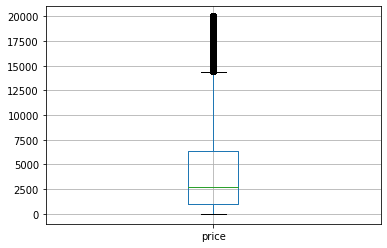

count    354077.000000
mean       4418.710484
std        4514.324828
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: price, dtype: float64

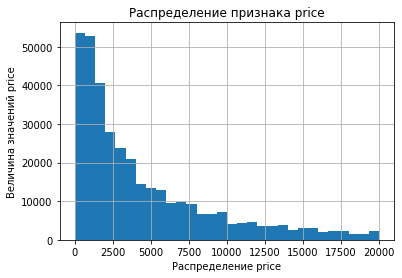

In [21]:
#Построим распределение и удалим аномальные значения для столбца 'price'
distribution(data_0, 'price')

**Вывод:** Обнаружены выбросы в данных, но мы не будем их удалять, так как они имеют равномерный характер, и их удаление может повредить анализу, так как их слишком много. Не все значения укладываются в 3 межквартильных размаха "ящика с усами". Медианное значение price равно 2700.0. Распределение значений имеет вид отличный от нормального.

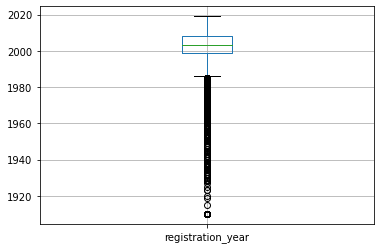

count    354077.000000
mean       2003.092548
std           7.515648
min        1910.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        2019.000000
Name: registration_year, dtype: float64

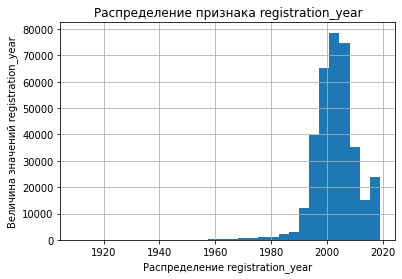

In [22]:
#Построим распределение и удалим аномальные значения для столбца 'registration_year'
distribution(data_0, 'registration_year')

**Вывод:** Обнаружены выбросы в данных, но мы не будем их удалять, так как они имеют равномерный характер, и их удаление может повредить анализу, так как их слишком много. Не все значения укладываются в 3 межквартильных размаха "ящика с усами". Медианное значение registration_year равно 2003.0. Распределение значений имеет вид близкий к нормальному.

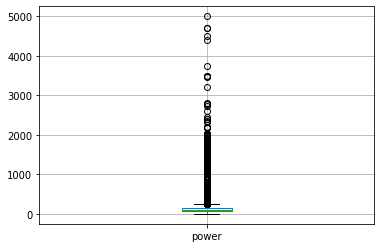

count    354077.000000
mean        119.053443
std          68.006554
min           1.000000
25%          75.000000
50%         109.000000
75%         143.000000
max        5000.000000
Name: power, dtype: float64

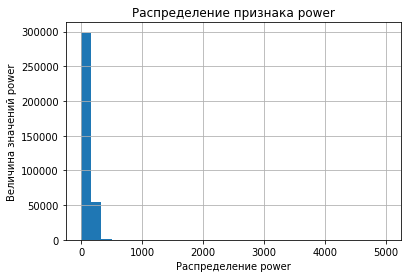

In [23]:
#Построим распределение и удалим аномальные значения для столбца 'power'
distribution(data_0, 'power')

**Вывод:** Обнаружены выбросы в данных, но мы не будем их удалять, так как они имеют равномерный характер, и их удаление может повредить анализу, так как их слишком много. Не все значения укладываются в 3 межквартильных размаха "ящика с усами". Медианное значение power равно 109.0. Распределение значений имеет вид близкий к нормальному.

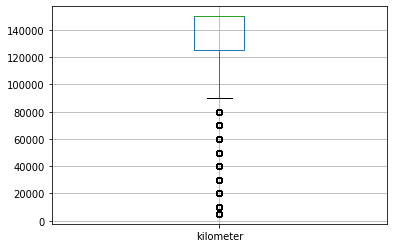

count    354077.000000
mean     128289.397504
std       37801.024969
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

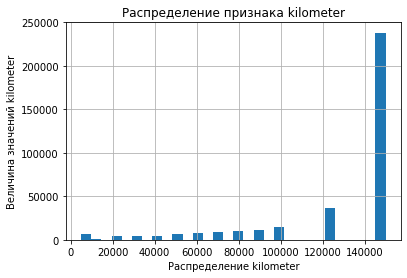

In [24]:
#Построим распределение и удалим аномальные значения для столбца 'kilometer'
distribution(data_0, 'kilometer')

**Вывод:** Обнаружены выбросы в данных, но мы не будем их удалять, так как они имеют равномерный характер, и их удаление может повредить анализу, так как их слишком много. Не все значения укладываются в 3 межквартильных размаха "ящика с усами". Медианное значение kilometer равно 150000.0. Распределение значений имеет вид отличный от нормального.

vehicle_type
bus            24591
convertible    18766
coupe          13403
not_found      62451
sedan          85990
small          76296
suv             9720
wagon          62860
Name: vehicle_type, dtype: int64

354077


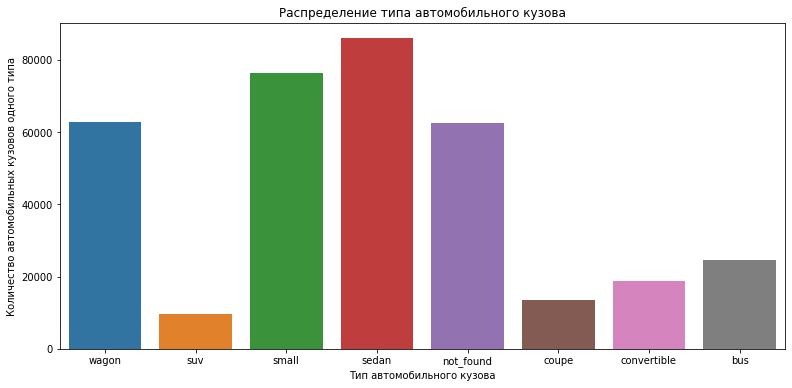

In [25]:
#Проверим распределение показателей и построим график для столбца 'vehicle_type'
display(data_0.groupby('vehicle_type')['vehicle_type'].count())

plt.figure(figsize=(13, 6))
sns.countplot(data_0['vehicle_type'].sort_values(ascending=False))
plt.title('Распределение типа автомобильного кузова')
plt.xlabel('Тип автомобильного кузова')
plt.ylabel('Количество автомобильных кузовов одного типа')
print(data_0['vehicle_type'].count())

**Вывод:** Распределение типа автомобильного кузова представлено 8 категориями - 'bus', 'convertible', 'coupe', 'not_found', 'sedan', 'small', 'suv', 'wagon'. Здесь можно примерно оценить распределение предпочтений автомобилистов. Больше всего предпочитают 'sedan' - более 80 тысяч. Меньше всего предпочитают 'suv' - около 10 тысяч.

gearbox
auto          66276
manual       268180
not_found     19621
Name: gearbox, dtype: int64

354077


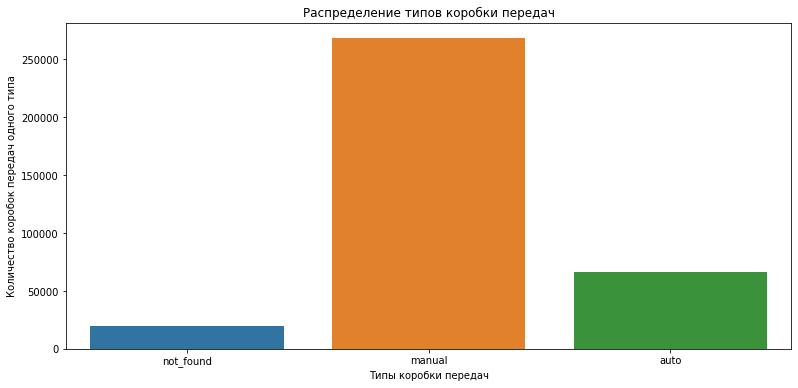

In [26]:
#Проверим распределение показателей и построим график для столбца 'gearbox'
display(data_0.groupby('gearbox')['gearbox'].count())

plt.figure(figsize=(13, 6))
sns.countplot(data_0['gearbox'].sort_values(ascending=False))
plt.title('Распределение типов коробки передач')
plt.xlabel('Типы коробки передач')
plt.ylabel('Количество коробок передач одного типа')
print(data_0['gearbox'].count())

**Вывод:** Распределение типов коробки передач представлено 3 категориями - 'auto', 'manual', 'not_found'. Здесь можно примерно оценить распределение предпочтений автомобилистов. Больше всего предпочитают 'manual' - более 250 тысяч. Меньше всего предпочитают 'auto' - около 55 тысяч.

model
range_rover_evoque        2
rangerover                3
serie_3                   4
serie_2                   5
samara                    5
                      ...  
corsa                 12542
polo                  13039
3er                   19556
golf                  29026
not_found             46104
Name: model, Length: 249, dtype: int64

354077


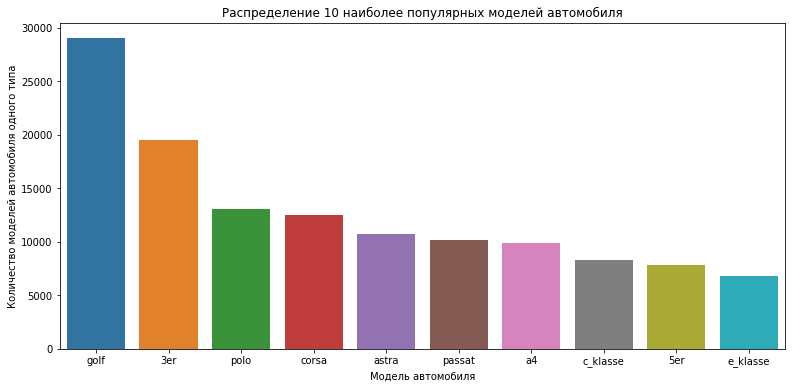

In [27]:
#Проверим распределение показателей и построим график для топ 10 столбца 'model'
display(data_0.groupby('model')['model'].count().sort_values())

plt.figure(figsize=(13, 6))
sns.countplot(x='model', data=data_0, order=pd.value_counts(data_0['model']).iloc[1:11].index)
plt.title('Распределение 10 наиболее популярных моделей автомобиля')
plt.xlabel('Модель автомобиля')
plt.ylabel('Количество моделей автомобиля одного типа')
print(data_0['model'].count())

**Вывод:** Распределение популярных моделей автомобиля представлено множеством категорий. 5 наиболее популярных это - 'golf', '3er', 'polo', 'corsa' и 'astra'. Можно примерно оценить распределение предпочтений автомобилистов. Больше всего предпочитают 'golf' - более 280 тысяч. Меньше всего предпочитают 'range_rover_evoque' - 2 человека.

fuel_type
cng             518
electric         44
gasoline      91817
hybrid          157
lpg            4636
not_found     57535
petrol       199370
Name: fuel_type, dtype: int64

354077


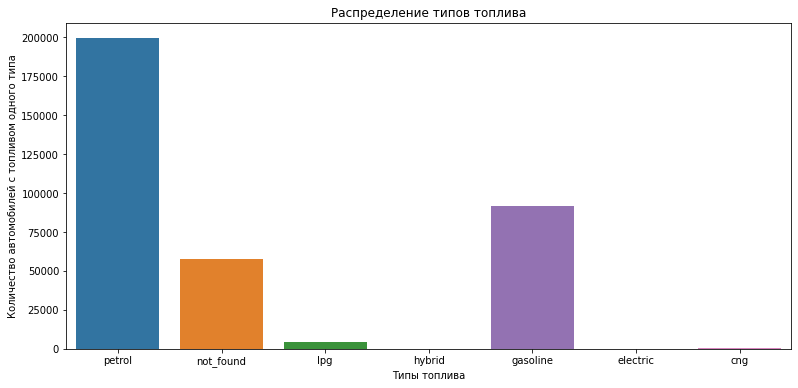

In [28]:
#Проверим распределение показателей и построим график для столбца 'fuel_type'
display(data_0.groupby('fuel_type')['fuel_type'].count())

plt.figure(figsize=(13, 6))
sns.countplot(data_0['fuel_type'].sort_values(ascending=False))
plt.title('Распределение типов топлива')
plt.xlabel('Типы топлива')
plt.ylabel('Количество автомобилей с топливом одного типа')
print(data_0['fuel_type'].count())

**Вывод:** Распределение типов топлива автомобиля представлено 7 категориями - 'cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'not_found', 'petrol'. Можно примерно оценить распределение предпочтений автомобилистов. Больше всего предпочитают 'petrol' - около 200 тысяч. Меньше всего предпочитают 'hybrid' - 157 человек.

brand
lada                217
lancia              471
trabant             478
rover               485
jaguar              505
saab                525
land_rover          542
daewoo              542
jeep                676
porsche             756
subaru              759
daihatsu            806
dacia               900
chrysler           1438
chevrolet          1752
alfa_romeo         2312
suzuki             2322
kia                2465
honda              2817
mitsubishi         3019
mini               3201
volvo              3210
sonstige_autos     3338
hyundai            3586
toyota             4606
nissan             4941
citroen            5145
smart              5246
skoda              5498
mazda              5609
seat               6906
fiat               9637
peugeot           10996
renault           17923
ford              25174
audi              29451
mercedes_benz     32032
bmw               36902
opel              39913
volkswagen        76976
Name: brand, dtype: int64

354077


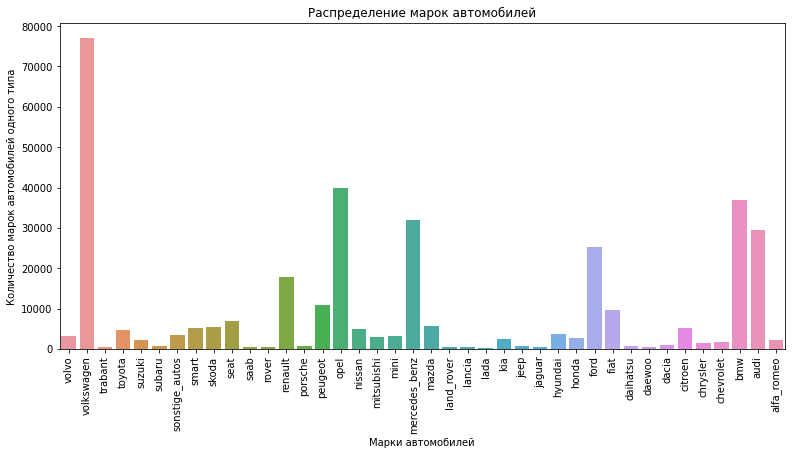

In [29]:
#Проверим распределение показателей и построим график для столбца 'brand'
display(data_0.groupby('brand')['brand'].count().sort_values())

plt.figure(figsize=(13, 6))
sns.countplot(data_0['brand'].sort_values(ascending=False))
plt.title('Распределение марок автомобилей')
plt.xlabel('Марки автомобилей')
plt.ylabel('Количество марок автомобилей одного типа')
plt.xticks(rotation = 90)
print(data_0['brand'].count())

**Вывод:** Распределение марок автомобилей представлено множеством категорий. 5 наиболее популярных, это - 'volkswagen', 'opel', 'bmw', 'mercedes_benz', 'audi'. Можно примерно оценить распределение предпочтений автомобилистов. Больше всего предпочитают 'volkswagen' - около 75 тысяч. Меньше всего предпочитают 'lada' - 217 человек.

repaired
no           247122
not_found     70916
yes           36039
Name: repaired, dtype: int64

354077


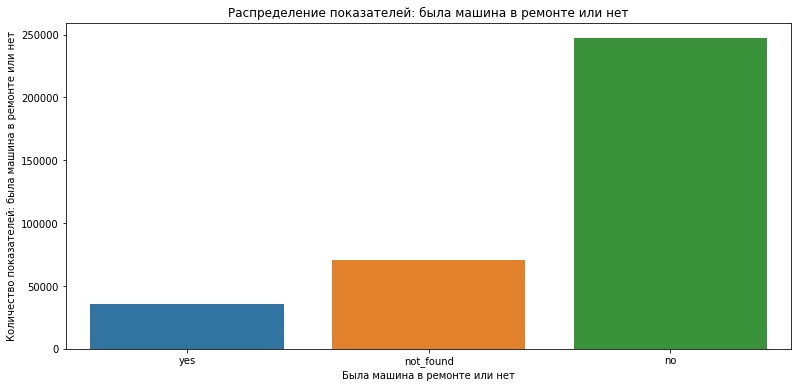

In [30]:
#Проверим распределение показателей и построим график для столбца 'repaired'
display(data_0.groupby('repaired')['repaired'].count())

plt.figure(figsize=(13, 6))
sns.countplot(data_0['repaired'].sort_values(ascending=False))
plt.title('Распределение показателей: была машина в ремонте или нет')
plt.xlabel('Была машина в ремонте или нет')
plt.ylabel('Количество показателей: была машина в ремонте или нет')
print(data_0['repaired'].count())

**Вывод:** Распределение показателей: была машина в ремонте или нет представлено тремя типами - 'yes', 'no', 'not_found'. Машин бывших в ремонте - 36039, не ремонтировавшихся машин - 247122.

**Оформим общий вывод по результатам шага.**

**Вывод:** 
- Некоторые входные признаки в датасетах распределены не нормально.
- В датасетах были обнаружены аномальные значения, мы не стали их убирать, т.к. из-за их количества это может повредить данным. 
- Мы изучили категориальные переменные и увидели предпочтения автомобилистов.

### Корреляционный анализ.

**Проведем корреляционный анализ данных в датасете data_0.**

,registration_year,power,kilometer
registration_year,1.000000,0.157707,-0.295658
power,0.157707,1.000000,0.121073
kilometer,-0.295658,0.121073,1.000000


<AxesSubplot:>

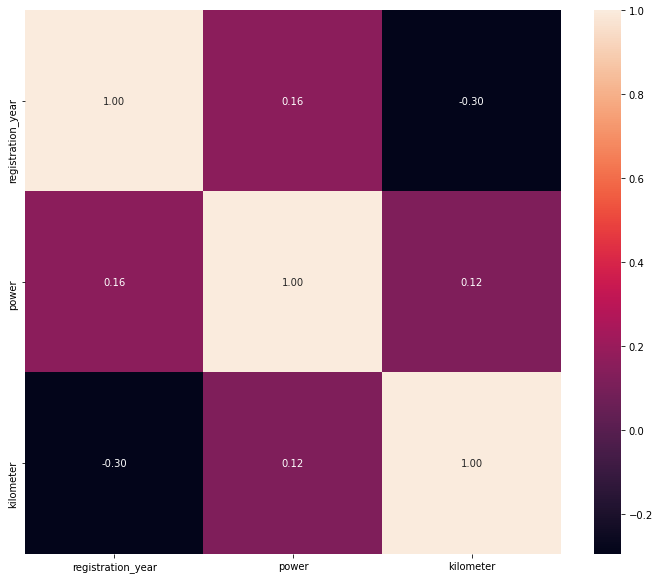

In [31]:
#Измерим корреляцию между признаками в датасете data_0
#Уберем столбец 'id'
data_0_corr = data_0.drop('price', axis=1)
#Используем корреляцию Спирмана, так как не все признаки распределены нормально
data_0_corr = data_0_corr.corr(method='spearman')
display(data_0_corr)
plt.figure(figsize=(12, 10))
sns.heatmap(data_0_corr, annot=True, fmt='.2f')

**Вывод:**

Мы обнаружили среднюю корреляцию между параметрами:
 - 'kilometer' и 'registration_year' = -0.30.
 
Так же существует низкая корреляция между параметрами:
 - 'power' и 'registration_year' = 0.16.
 - 'kilometer' и 'power' = 0.12.
 
Между остальными параметрами корреляции нет.

## Обучение моделей

### Подготовка признаков.

In [32]:
data_0.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,not_found,1993,manual,95,golf,150000,petrol,volkswagen,not_found
1,18300,coupe,2011,manual,190,not_found,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,not_found
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [33]:
# Определим категориальные признаки
cat_features = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# Определим количественные признаки
num_features = ['registration_year', 'power', 'kilometer']

data = data_0[num_features + cat_features];
data.head()

,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
0,1993,95,150000,not_found,manual,golf,petrol,volkswagen,not_found
1,2011,190,125000,coupe,manual,not_found,gasoline,audi,yes
2,2004,163,125000,suv,auto,grand,gasoline,jeep,not_found
3,2001,75,150000,small,manual,golf,petrol,volkswagen,no
4,2008,69,90000,small,manual,fabia,gasoline,skoda,no


In [34]:
# Выделим входные признаки и целевой
features = data
target = data_0['price']

# Подготовим категориальные признаки, используем OHE
features_ohe = pd.get_dummies(features, columns=cat_features, drop_first=True)
features_ohe.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_not_found,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_not_found,repaired_yes
0,1993,95,150000,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,2011,190,125000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,163,125000,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,2001,75,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,2008,69,90000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [35]:
# Разделим датасет на выборки
def train_valid_test_func(features, target):
    features_train, valid_test_features, target_train, valid_test_target = train_test_split(features, 
                                                                                            target, 
                                                                                            test_size=0.4, 
                                                                                            random_state=RANDOM_STATE)

    # Отделим тестовую выборку от валидационной
    features_valid, features_test, target_valid, target_test = train_test_split(valid_test_features, 
                                                                                valid_test_target, 
                                                                                test_size=0.5, 
                                                                                random_state=RANDOM_STATE)

    del valid_test_features, valid_test_target
    
    # Проверим результат
    print('target_test = {}, target_valid = {}, target_train = {}'.format(target_test.count(), 
                                                                                   target_valid.count(), 
                                                                                   target_train.count()))
    
    return features_train, target_train, features_valid, target_valid, features_test, target_test

In [36]:
# Разделим выборку на обучающую и тестовую
features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_func(features_ohe, target)

target_test = 70816, target_valid = 70815, target_train = 212446


In [37]:
# Скалируем количественные признаки
scaler = StandardScaler()

scaler.fit(features_train[num_features])

features_train[num_features] = scaler.transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])

features_train.head()

,registration_year,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_not_found,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_not_found,repaired_yes
351594,0.919719,0.175800,0.574749,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
294747,-0.941031,-0.264691,0.574749,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
260658,-0.675210,-0.426204,-0.748553,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
201090,-0.143567,-0.646449,-0.086902,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
172280,1.717183,-0.646449,0.574749,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0


In [38]:
# Определим функцию для подсчета RMSE
def rmse(target, predicted):
    return mse(target, predicted) ** 0.5

### Обучим модели.

**Протестируем модели: LinearRegression и RandomForestRegressor**

In [39]:
# Напишем класс в котором будем сохранять параметры обучения и RMSE

class ParamRemember:
    def __init__(self, name, model):
        self.name = name
        self.model = model
    
    def fit(self, features, target):
        start = time.time()    
        self.model.fit(features, target)
        end = time.time() - start
        self.fitTime = end
    
    def predict(self, features, target):
        start = time.time()  
        predicted = self.model.predict(features)
        end = time.time() - start
        self.predictedTime = end
        self.rmse = rmse(target, predicted)
    
    def getResult(self):
        return self.name, self.fitTime, self.predictedTime, self.rmse

In [40]:
# Создадим переменную, где будут храниться результаты
    
result = []

In [41]:
# Создадим функцию для вывода данных моделей
def show_result(result):
    print('|{: >25}|{: >25}|{: >25}|{: >25}|'.format('Модель', 'Время обучения', 'Время предсказания', 'RMSE'))
    for info in result:
        print('|{: >25}|{: >25.5f}|{: >25.5f}|{: >25.5f}|'.format(info[0], info[1], info[2], info[3]))

**Обучим LinearRegression**

In [42]:
# # Обучим модель LinearRegression
model_linreg = LinearRegression()

model_linreg_param = ParamRemember('LinearRegression', model_linreg)
model_linreg_param.fit(features_train, target_train)
model_linreg_param.predict(features_valid, target_valid)

result.append(model_linreg_param.getResult())

In [43]:
# Посмотрим на промежуточный результат
show_result(result)

|                   Модель|           Время обучения|       Время предсказания|                     RMSE|
|         LinearRegression|                 18.73126|                  0.21181|               2946.19042|


**Обучим RandomForestRegressor**

In [44]:
pd.options.mode.chained_assignment = None

# Выделим входные признаки и целевой
features = data
target = data_0['price']

# Разделим выборку на обучающую и тестовую
features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_func(features, target)

# Скалируем количественные признаки
scaler = StandardScaler()

scaler.fit(features_train[num_features])

features_train[num_features] = scaler.transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])

features_train.head()

target_test = 70816, target_valid = 70815, target_train = 212446


,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
351594,0.919719,0.175800,0.574749,wagon,manual,passat,gasoline,volkswagen,no
294747,-0.941031,-0.264691,0.574749,small,manual,golf,not_found,volkswagen,yes
260658,-0.675210,-0.426204,-0.748553,sedan,manual,escort,petrol,ford,no
201090,-0.143567,-0.646449,-0.086902,small,manual,ibiza,petrol,seat,not_found
172280,1.717183,-0.646449,0.574749,not_found,manual,golf,petrol,volkswagen,not_found


In [45]:
# Обработаем категориальные признаки для RandomForestRegressor
features_train_rfr = features_train.copy()
features_valid_rfr = features_valid.copy()

# Определим категориальные признаки
cat_features_rfr = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# Подготовим категориальные признаки, используем OrdinalEncoder
encoder = OrdinalEncoder()

encoder.fit(features_train_rfr[cat_features_rfr])

features_train_rfr[cat_features_rfr] = encoder.transform(features_train_rfr[cat_features_rfr])
features_valid_rfr[cat_features_rfr] = encoder.transform(features_valid_rfr[cat_features_rfr])

features_train_rfr.head()

,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
351594,0.919719,0.175800,0.574749,7.0,1.0,170.0,2.0,38.0,0.0
294747,-0.941031,-0.264691,0.574749,5.0,1.0,116.0,5.0,38.0,2.0
260658,-0.675210,-0.426204,-0.748553,4.0,1.0,98.0,6.0,10.0,0.0
201090,-0.143567,-0.646449,-0.086902,5.0,1.0,120.0,6.0,30.0,1.0
172280,1.717183,-0.646449,0.574749,3.0,1.0,116.0,6.0,38.0,1.0


In [46]:
%%time

# Обучим модель RandomForestRegressor, и с помощью %%time узнаем время обучения
params = {'n_estimators': range(5,11,5),
          'max_depth': range(1,8,3), 
          'min_samples_leaf': range(1,5,2), 
          'min_samples_split': range(2,6,2)}

model = RandomForestRegressor()

grid_sear_cv = GridSearchCV(model, 
                            params, 
                            cv=3, 
                            scoring='neg_mean_squared_error')

grid_sear_cv.fit(features_train_rfr, target_train)

grid_sear_cv.best_params_

CPU times: user 46.7 s, sys: 0 ns, total: 46.7 s
Wall time: 46.7 s


{'max_depth': 7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 10}

In [47]:
# Проверим RandomForestRegressor
model_forest = RandomForestRegressor(max_depth=7, 
                                     min_samples_leaf=3, 
                                     min_samples_split=4, 
                                     n_estimators=10, 
                                     random_state=RANDOM_STATE)

model_forest_param = ParamRemember('RandomForestRegressor', model_forest)
model_forest_param.fit(features_train_rfr, target_train)
model_forest_param.predict(features_valid_rfr, target_valid)

result.append(model_forest_param.getResult())

In [48]:
# Посмотрим на промежуточный результат
show_result(result)

|                   Модель|           Время обучения|       Время предсказания|                     RMSE|
|         LinearRegression|                 18.73126|                  0.21181|               2946.19042|
|    RandomForestRegressor|                  2.00783|                  0.04333|               2266.72068|


### Подготовка признаков для градиентного бустинга.

In [49]:
pd.options.mode.chained_assignment = None

# Выделим входные признаки и целевой
features = data
target = data_0['price']

# Разделим выборку на обучающую и тестовую
features_train, target_train, features_valid, target_valid, features_test, target_test = train_valid_test_func(features, target)

# Скалируем количественные признаки
scaler = StandardScaler()

scaler.fit(features_train[num_features])

features_train[num_features] = scaler.transform(features_train[num_features])
features_valid[num_features] = scaler.transform(features_valid[num_features])
features_test[num_features] = scaler.transform(features_test[num_features])

features_train.head()

target_test = 70816, target_valid = 70815, target_train = 212446


,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
351594,0.919719,0.175800,0.574749,wagon,manual,passat,gasoline,volkswagen,no
294747,-0.941031,-0.264691,0.574749,small,manual,golf,not_found,volkswagen,yes
260658,-0.675210,-0.426204,-0.748553,sedan,manual,escort,petrol,ford,no
201090,-0.143567,-0.646449,-0.086902,small,manual,ibiza,petrol,seat,not_found
172280,1.717183,-0.646449,0.574749,not_found,manual,golf,petrol,volkswagen,not_found


In [50]:
# Обработаем категориальные признаки для LGBM
features_train_lgbm = features_train.copy()
features_valid_lgbm = features_valid.copy()
features_test_lgbm = features_test.copy()

# Определим категориальные признаки
cat_features_lgbm = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

# Подготовим категориальные признаки, используем OrdinalEncoder
encoder = OrdinalEncoder()

encoder.fit(features_train_lgbm[cat_features_lgbm])

features_train_lgbm[cat_features_lgbm] = encoder.transform(features_train_lgbm[cat_features_lgbm])
features_valid_lgbm[cat_features_lgbm] = encoder.transform(features_valid_lgbm[cat_features_lgbm])
features_test_lgbm[cat_features_lgbm] = encoder.transform(features_test_lgbm[cat_features_lgbm])

features_train_lgbm.head()

,registration_year,power,kilometer,vehicle_type,gearbox,model,fuel_type,brand,repaired
351594,0.919719,0.175800,0.574749,7.0,1.0,170.0,2.0,38.0,0.0
294747,-0.941031,-0.264691,0.574749,5.0,1.0,116.0,5.0,38.0,2.0
260658,-0.675210,-0.426204,-0.748553,4.0,1.0,98.0,6.0,10.0,0.0
201090,-0.143567,-0.646449,-0.086902,5.0,1.0,120.0,6.0,30.0,1.0
172280,1.717183,-0.646449,0.574749,3.0,1.0,116.0,6.0,38.0,1.0


**Обучим LightGBM**

In [51]:
%%time

# Обучим модель LGBMRegressor, и с помощью %%time узнаем время обучения
lgbm = LGBMRegressor(boosting_type='gbdt', 
                     verbose=-1, 
                     seed=RANDOM_STATE)

lgbm_params = {'learning_rate': np.logspace(-3, 0, 5), 
              'n_estimators': range(20, 61, 20), 
              'num_leaves': range(20, 41, 10)}

grid_lgbm = GridSearchCV(lgbm, 
                         lgbm_params, 
                         cv=3, 
                         scoring='neg_mean_squared_error')

grid_lgbm.fit(features_train_lgbm, target_train);

grid_lgbm.best_params_

CPU times: user 4min 5s, sys: 895 ms, total: 4min 6s
Wall time: 4min 9s


{'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 40}

In [52]:
# Проверим LGBMRegressor
model_lgbm = grid_lgbm.best_estimator_

model_lgbm_param = ParamRemember('LGBMRegressor', model_lgbm)
model_lgbm_param.fit(features_train_lgbm, target_train)
model_lgbm_param.predict(features_valid_lgbm, target_valid)

result.append(model_lgbm_param.getResult())

**Обучим CatBoostRegressor**

In [53]:
%%time

# Обучим модель CatBoostRegressor, и с помощью %%time узнаем время обучения
cat_br = CatBoostRegressor(loss_function='RMSE',
                        silent=True, 
                        cat_features=cat_features, 
                        random_seed=RANDOM_STATE)

cat_br_params = {'learning_rate': np.logspace(-3, 0, 5),
              'iterations': range(20, 60, 20),
              'depth': range(5,10,2)}

grid_cat_br = GridSearchCV(cat_br, 
                        cat_br_params, 
                        cv=3, 
                        scoring='neg_mean_squared_error')

grid_cat_br.fit(features_train, target_train);

grid_cat_br.best_params_

CPU times: user 3min 41s, sys: 2.88 s, total: 3min 44s
Wall time: 4min 43s


{'depth': 9, 'iterations': 40, 'learning_rate': 1.0}

In [54]:
# Проверим CatBoostRegressor
model_cat_br = grid_cat_br.best_estimator_
_
model_cat_br_param = ParamRemember(' CatBoostRegressor', model_cat_br)
model_cat_br_param.fit(features_train, target_train)
model_cat_br_param.predict(features_valid, target_valid)

result.append(model_cat_br_param.getResult())

## Анализ моделей

In [55]:
# Посмотрим на промежуточный результат
show_result(result)

|                   Модель|           Время обучения|       Время предсказания|                     RMSE|
|         LinearRegression|                 18.73126|                  0.21181|               2946.19042|
|    RandomForestRegressor|                  2.00783|                  0.04333|               2266.72068|
|            LGBMRegressor|                  2.79772|                  0.39948|               1859.82358|
|        CatBoostRegressor|                  5.94739|                  0.16386|               1894.66772|


Для использования в данном проекте были выбраны следующие модели: RandomForestRegressor, LinearRegression, LGBMRegressor и CatBoostRegressor.

По критерию минимального параметра RMSE в качестве лучшей модели после обучения была выбрана модель LGBMRegressor с параметрами {'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 40}. Ее показатели на тестовой выборке:

- RMSE: 1859.82358
- Время обучения: (без учёта подбора гиперпараметров): 3.14019с
- Время предсказания: 0.39982с

Эта модель несильно проигрывает во времени обучения и предсказания модели RandomForestRegressor, зато качественно выигрывает в показателе RMSE. Мы предлагаем её, как лучшую из протестированных моделей.

**Протестируем выбранную нами модель с гиперпараметрами на тестовой выборке.**

In [56]:
%%time

# Обучим модель LGBMRegressor, и с помощью %%time узнаем время обучения
lgbm = LGBMRegressor(boosting_type='gbdt', 
                     verbose=-1, 
                     seed=42,
                     learning_rate=0.1778279410038923,
                     n_estimators=60,
                     num_leaves=40)


lgbm.fit(features_train_lgbm, target_train)

predictions = lgbm.predict(features_test_lgbm)

lgbm_rmse = rmse(target_test, predictions)
lgbm_rmse

CPU times: user 3.21 s, sys: 9 ms, total: 3.22 s
Wall time: 3.21 s


1836.9439958774658

RMSE на тестовой выборке оказался ниже, чем 2500 (1836.94) а время предсказания меньше, чем на валидационной выборке. Учитывая то, что заказчика интересуют время обучения и предсказания, и RMSE ниже 2500 для эксплуатации можем предложить модель:

- LGBMRegressor с параметрами: {'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 40}.

## Общий вывод.

**Сделаем общий вывод по проделанному исследованию.**

Мы исследовали датасет с данными о технических характеристиках, комплектации и ценах других автомобилей. Мы создавали модель, которая умеет определять рыночную стоимость автомобиля.

Заказчику были важны критерии:

- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Сделаем выводы по обзору данных:**

 - В исследовани участвует один датасет.
 - В столбцах датасета разное количество значений.
 - В датасете обнаружены пропуски.
 - В датасете обнаружены неправильные типы данных.
 - Данные в таблице соответствуют описанию.
 - Названия столбцов не приведены к змеиному регистру.
 - Мы можем определить следующие признаки неинформативными для моделей машинного обучения:
 - 1.DateCrawled — дата скачивания анкеты из базы.
 - 2.RegistrationMonth — месяц регистрации автомобиля.
 - 3.DateCreated — дата создания анкеты.
 - 4.NumberOfPictures — количество фотографий автомобиля (признак содержит только нули).
 - 5.PostalCode — почтовый индекс владельца анкеты.
 - 6.LastSeen — дата последней активности пользователя.
 
**Сделаем выводы по предобработке данных:**

- Все столбцы и значения в категориальных столбцах были переведены в змеиный регистр.
- Были обнаружены и удалены явные дубликаты.
- Неявных дубликатов обнаружено не было.
- Значения Nan в датасете были заменены на 'not_found'.
- Значения в столбце 'power' выше 5000 и ниже 1 были заменены на медианные по группе признаков 'model' и 'brand'.

**Сделаем вывод по исследовательскому анализу данных:**

- Некоторые входные признаки в датасетах распределены не нормально.
- В датасетах были обнаружены аномальные значения, мы не стали их убирать, т.к. из-за их количества это может повредить данным. 
- Мы изучили категориальные переменные и увидели предпочтения автомобилистов.

**Сделаем вывод по корреляционному анализу данных:**

Мы обнаружили среднюю корреляцию между параметрами:
 - 'kilometer' и 'registration_year' = -0.30.
 
Так же существует низкая корреляция между параметрами:
 - 'power' и 'registration_year' = 0.16.
 - 'kilometer' и 'power' = 0.12.
 
Между остальными параметрами корреляции нет.

 - Мы использовали корреляцию Спирмана, так как некоторые данные распределены не нормально.
 
**Вывод по анализу моделей:**

Для использования в данном проекте были выбраны следующие модели: RandomForestRegressor, LinearRegression, LGBMRegressor и CatBoostRegressor.

По критерию минимального параметра RMSE в качестве лучшей модели после обучения была выбрана модель LGBMRegressor с параметрами {'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 40}. Ее показатели на тестовой выборке:

- RMSE: 1859.82358
- Время обучения: (без учёта подбора гиперпараметров): 3.14019с
- Время предсказания: 0.39982с

Эта модель несильно проигрывает во времени обучения и предсказания модели RandomForestRegressor, зато качественно выигрывает в показателе RMSE. Мы предлагаем её, как лучшую из протестированных моделей.

**Вывод по тестированию модели:**

RMSE на тестовой выборке оказался ниже, чем 2500 (1836.94) а время предсказания меньше, чем на валидационной выборке. Учитывая то, что заказчика интересуют время обучения и предсказания, и RMSE ниже 2500 для эксплуатации можем предложить модель:

- LGBMRegressor с параметрами: {'learning_rate': 0.1778279410038923, 'n_estimators': 60, 'num_leaves': 40}.